In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import importlib
import pickle

# functions for this project
import multithreadTD as models

In [2]:
# simulation parameters
dt = 0.1
d_max = int(8/dt)
t_max = int(9/dt)

tpts = np.arange(0,t_max*dt,dt)

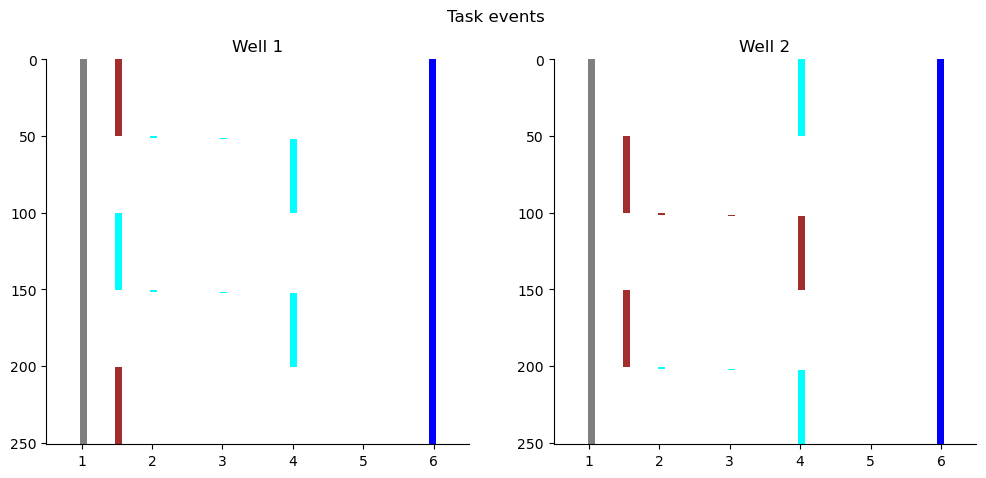

In [3]:
# task events
# includes both the delay and identity transitions
blocktr = 50
nblock = 5
ntr = blocktr*nblock

importlib.reload(models)
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

# cue == 1, terminal reward == 2, chocolate == 3, vanilla == 4

# helper function to build event matrix for each well
well1, well2 = models.createTask(dt,t_max,ntr,blocktr)

colors = ["white", "gray", "blue", "brown","cyan"]
cmap1 = LinearSegmentedColormap.from_list("mycmap", colors)

fig,ax = plt.subplots(1,2,figsize=[12,5])
w1 = ax[0].imshow(well1,aspect='auto',cmap=cmap1,extent=[tpts[0],tpts[-1],ntr+1,0],interpolation="nearest")
ax[0].set_title('Well 1')
ax[0].set(xlim=[0.5,6.5])
# fig.colorbar(w1,ax=ax[0])
w2 = ax[1].imshow(well2,aspect='auto',cmap=cmap1,extent=[tpts[0],tpts[-1],ntr+1,0],interpolation="nearest")
ax[1].set_title('Well 2')
ax[1].set(xlim=[0.5,6.5])
# fig.colorbar(w2,ax=ax[1])

fig.suptitle('Task events')

sns.despine()


# Baseline models

## Figure 5. TD($\lambda$) without reset



(0.0, 1.0, 0.0, 1.0)

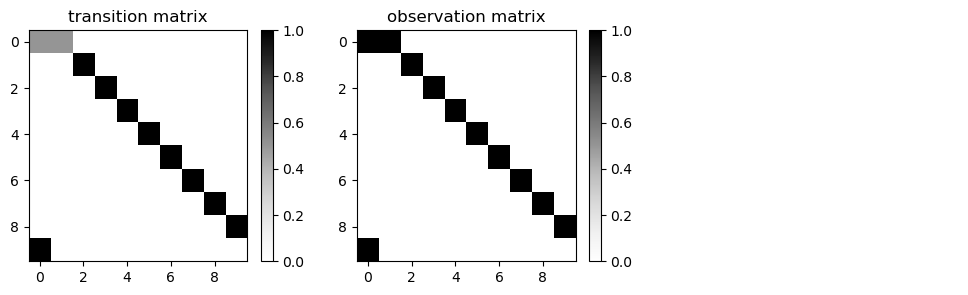

In [4]:

nstates = int(d_max) + 1 # timepoint states for cued states and single ITI state
model = 1
nids = 1

# build transition matrix
T = models.createTransitionMatrix(nstates,model,nids)

# check we have the right shape for this number of identities
T.shape

# build observation matrix
# now O is 3-d 
# corresponds to observation emitted on transition from s_t to s_(t+1)
O = models.createObservationMatrix3D(nstates,model,nids)

# we will map states within a thread to taskstates (for eligibility)
# these are straightforward for the simple single thread (nid=1) models
taskstates = np.zeros([nstates,2],dtype='bool')
taskstates[0,0] = True
taskstates[1:,1] = True

# map observations to reward amount
reward = np.zeros(O.shape[1])
reward[2:] = 1

# plot these to check
fig,ax = plt.subplots(1,3,figsize=[12,3])
ax.ravel()

c1 = ax[0].imshow(T[np.append(np.arange(0,9),T.shape[0]-1),:10],aspect='auto',cmap='Greys')

ax[0].set_title('transition matrix')
fig.colorbar(c1, ax=ax[0])

c2 = ax[1].imshow(O[np.append(np.arange(0,9),T.shape[0]-1),:10,:].sum(axis=2),aspect='auto',cmap='Greys')
ax[1].set_title('observation matrix') # \n (3D not plotted here)')
fig.colorbar(c2, ax=ax[1])

ax[2].axis('off')

# plt.savefig('Figure5a_classicTD_noreset_transition.png', bbox_inches="tight")



In [5]:
# now we can compute TD learning over this structure

eta = 0.4
gamma = 0.95
elambda = 1
decay = 0.1

state1, nextstate1, w1, elig1, v1, nextv1, rpe1, thread1 = models.TDlambda(well1, T, O, taskstates, reward, eta, gamma, elambda, decay)


In [6]:
# and the second well
state2, nextstate2, w2, elig2, v2, nextv2, rpe2, thread2 = models.TDlambda(well2, T, O, taskstates, reward, eta, gamma, elambda, decay)


Text(0.5, 1.0, 'threads')

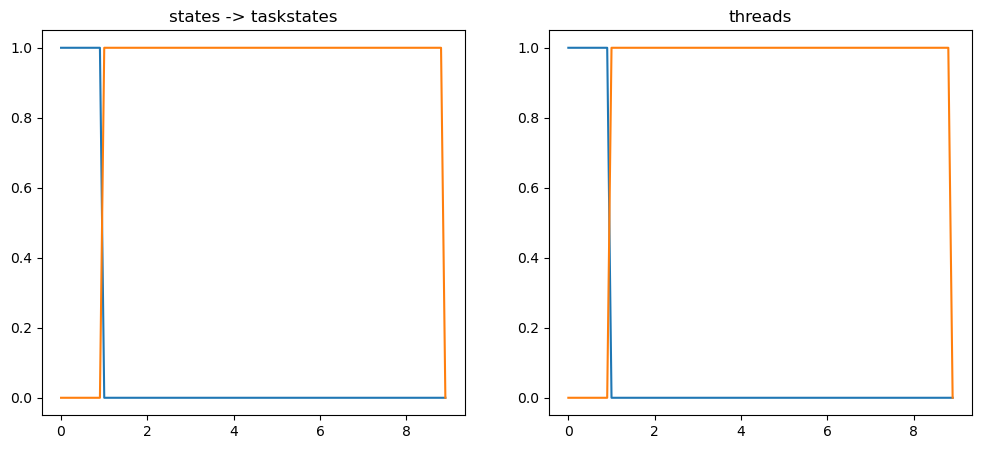

In [7]:
# check state trajectories against taskstate trajectories

fig, ax = plt.subplots(1,2,figsize=[12,5])
ax[0].plot(tpts,(np.squeeze(state1[0,:,:]).T)@taskstates)
ax[0].set_title('states -> taskstates')
ax[1].plot(tpts,thread1[0,:,:].T)
ax[1].set_title('threads')

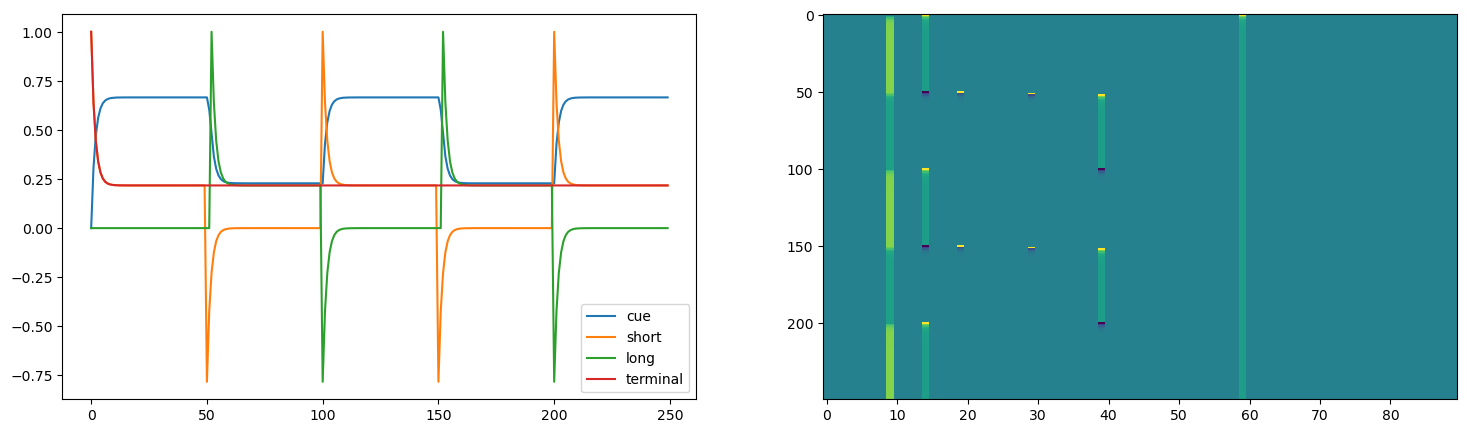

In [8]:
# RPE through task

t_cue = np.where(tpts==1)[0][0] - 1
t_short = np.where(tpts==1.5)[0][0] - 1
t_long = np.where(tpts==4)[0][0] - 1
t_terminal = np.where(tpts==6)[0][0] - 1

fig,ax = plt.subplots(1,2,figsize=[18,5])

ax[0].plot(rpe1[:,[t_cue,t_short,t_long,t_terminal]])
ax[0].legend(["cue","short",'long','terminal'],loc="lower right")

ax[1].imshow(rpe1,aspect='auto',interpolation='nearest')


In [9]:
# for Figure components

xfont = 14
xlim = 6

Text(0.43, 0.98, 'well 1')

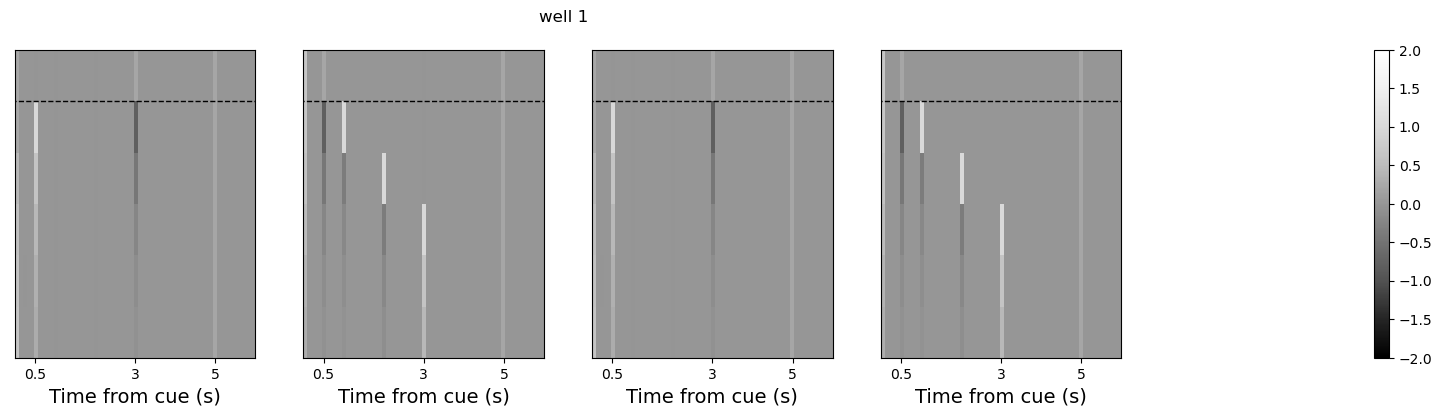

In [10]:
# well 1

colors = ["darkblue","blue", "lightgray", "red","darkred"]
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors)
# colors_grey = ["black","dimgray","lightgray","whitesmoke","white"]
colors_grey = ["white","whitesmoke","lightgray","dimgray","black"]
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors_grey)
cmap2 = "Greys_r"


well1_shortsame = np.arange((blocktr*2-1),(blocktr*2+5))
well1_longsame = np.arange((blocktr*3-1),(blocktr*3+5))
well1_shortdiff = np.arange((blocktr*4-1),(blocktr*4+5))
well1_longdiff = np.arange((blocktr-1),(blocktr+5))

fig,ax = plt.subplots(1,5,figsize=[18,4])

cbar = ax[0].imshow(rpe1[well1_shortsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(rpe1[well1_longsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(rpe1[well1_shortdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[2].set(xlim=[1,xlim+1])
ax[2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(rpe1[well1_longdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[3].set(xlim=[1,xlim+1])
ax[3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[4].axis('off')

fig.colorbar(cbar,ax=ax[4])

fig.suptitle('well 1',x=0.43)



Text(0.43, 0.98, 'well 2')

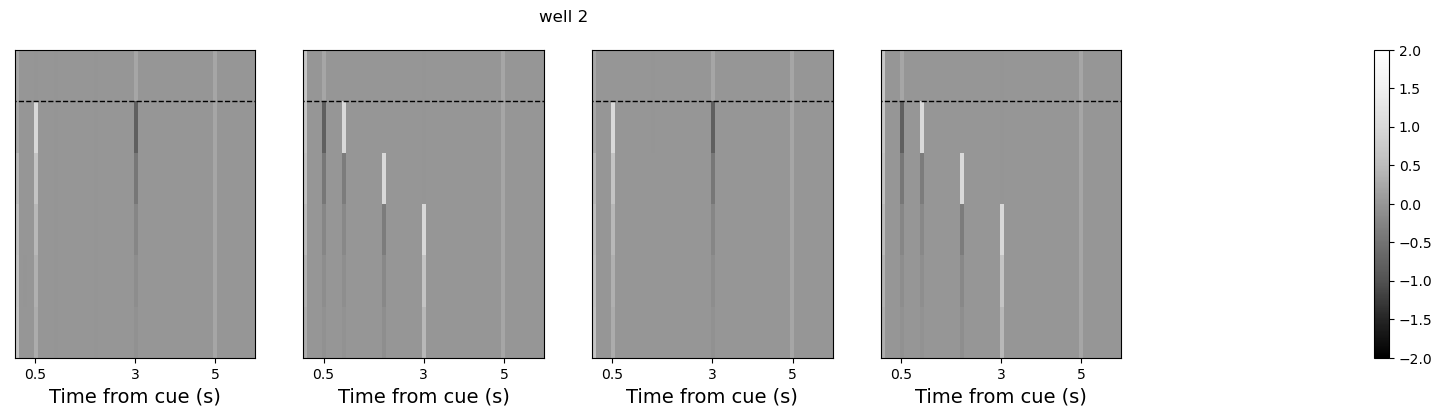

In [11]:
# well 2

well2_shortsame = np.arange((blocktr*3-1),(blocktr*3+5))
well2_longsame = np.arange((blocktr*2-1),(blocktr*2+5))
well2_shortdiff = np.arange((blocktr-1),(blocktr+5))
well2_longdiff = np.arange((blocktr*4-1),(blocktr*4+5))

fig,ax = plt.subplots(1,5,figsize=[18,4])

cbar = ax[0].imshow(rpe2[well2_shortsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(rpe2[well2_longsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(rpe2[well2_shortdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[2].set(xlim=[1,xlim+1])
ax[2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(rpe2[well2_longdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[3].set(xlim=[1,xlim+1])
ax[3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[4].axis('off')

fig.colorbar(cbar,ax=ax[4])


fig.suptitle('well 2',x=0.43)



(0.0, 1.0, 0.0, 1.0)

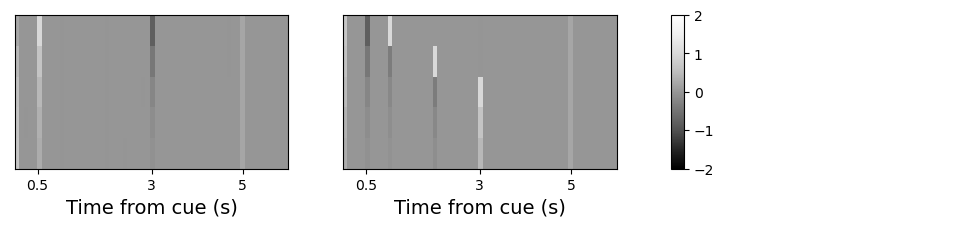

In [12]:
# combine these two wells into the average 


colors = ["darkblue","blue", "lightgray", "red","darkred"]
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors)

cmap = cmap2
# cmap = 'jet'
cmap = "Greys_r"

fig,ax = plt.subplots(1,3,figsize=[12,2])


shortsame = (rpe1[(blocktr*2):(blocktr*2+5),:] + rpe2[(blocktr*3):(blocktr*3+5),:])/2
longsame = (rpe1[(blocktr*3):(blocktr*3+5),:] + rpe2[(blocktr*2):(blocktr*2+5),:])/2
shortdiff = (rpe1[(blocktr*4):(blocktr*4+5),:] + rpe2[(blocktr):(blocktr+5),:])/2
longdiff = (rpe1[(blocktr):(blocktr+5),:] + rpe2[(blocktr*4):(blocktr*4+5),:])/2

cbar = ax[0].imshow((shortsame+shortdiff)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow((longsame+longdiff)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("left", size="5%", pad=0.05)
fig.colorbar(cbar,ax=ax[2],cax=cax)

ax[2].axis('off')

# plt.savefig('Figure5a_classicTD_noreset_RPE.png', bbox_inches="tight")


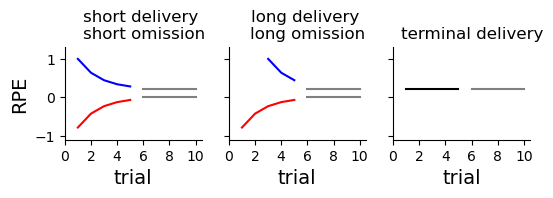

In [13]:
# rpe through block (combined wells)


ntr = 5
tr_index = np.zeros([2,5,ntr],dtype='int') # early/late, block, tr index
for b in range(5):
    tr_index[0,b,:] = np.arange(blocktr*b,blocktr*b+ntr)
    tr_index[1,b,:] = np.arange(blocktr*(b+1)-ntr,blocktr*(b+1))

fig,ax = plt.subplots(1,3,figsize=[6,1.2])

shortdel1a = rpe1[tr_index[:,2,:].flatten(),t_short]
shortdel1b = rpe1[tr_index[:,4,:].flatten(),t_short]
shortdel2a = rpe2[tr_index[:,3,:].flatten(),t_short]
shortdel2b = rpe2[tr_index[:,1,:].flatten(),t_short]
shortdelivery_early = (shortdel1a[:ntr] + shortdel1b[:ntr] + shortdel2a[:ntr] + shortdel2b[:ntr])/4
shortdelivery_late = (shortdel1a[ntr:] + shortdel1b[ntr:] + shortdel2a[ntr:] + shortdel2b[ntr:])/4

longdel1a = rpe1[tr_index[:,3,:].flatten(),t_long]
longdel1b = rpe1[tr_index[:,1,:].flatten(),t_long]
longdel2a = rpe2[tr_index[:,2,:].flatten(),t_long]
longdel2b = rpe2[tr_index[:,4,:].flatten(),t_long]
longdelivery_early = (longdel1a[2:ntr] + longdel1b[2:ntr] + longdel2a[2:ntr] + longdel2b[2:ntr])/4
longdelivery_late = (longdel1a[ntr:] + longdel1b[ntr:] + longdel2a[ntr:] + longdel2b[ntr:])/4

shortom1a = rpe1[tr_index[:,3,:].flatten(),t_short]
shortom1b = rpe1[tr_index[:,1,:].flatten(),t_short]
shortom2a = rpe2[tr_index[:,2,:].flatten(),t_short]
shortom2b = rpe2[tr_index[:,4,:].flatten(),t_short]
shortomission_early = (shortom1a[:ntr] + shortom1b[:ntr] + shortom2a[:ntr] + shortom2b[:ntr])/4
shortomission_late = (shortom1a[ntr:] + shortom1b[ntr:] + shortom2a[ntr:] + shortom2b[ntr:])/4

longom1a = rpe1[tr_index[:,2,:].flatten(),t_long]
longom1b = rpe1[tr_index[:,4,:].flatten(),t_long]
longom2a = rpe2[tr_index[:,3,:].flatten(),t_long]
longom2b = rpe2[tr_index[:,1,:].flatten(),t_long]
longomission_early = (longom1a[:ntr] + longom1b[:ntr] + longom2a[:ntr] + longom2b[:ntr])/4
longomission_late = (longom1a[ntr:] + longom1b[ntr:] + longom2a[ntr:] + longom2b[ntr:])/4

terminal1a_short = rpe1[tr_index[:,2,:].flatten(),t_terminal]
terminal1b_short = rpe1[tr_index[:,4,:].flatten(),t_terminal]
terminal2a_short = rpe2[tr_index[:,3,:].flatten(),t_terminal]
terminal2b_short = rpe2[tr_index[:,1,:].flatten(),t_terminal]
terminal1a_long = rpe1[tr_index[:,3,:].flatten(),t_terminal]
terminal1b_long = rpe1[tr_index[:,1,:].flatten(),t_terminal]
terminal2a_long = rpe2[tr_index[:,2,:].flatten(),t_terminal]
terminal2b_long = rpe2[tr_index[:,4,:].flatten(),t_terminal]

terminaldelivery_early = (terminal1a_short[:ntr] + terminal1b_short[:ntr] + terminal2a_short[:ntr] + terminal2b_short[:ntr] +\
                    terminal1a_long[:ntr] + terminal1b_long[:ntr] + terminal2a_long[:ntr] + terminal2b_long[:ntr])/8
terminaldelivery_late = (terminal1a_short[ntr:] + terminal1b_short[ntr:] + terminal2a_short[ntr:] + terminal2b_short[ntr:] +\
                    terminal1a_long[ntr:] + terminal1b_long[ntr:] + terminal2a_long[ntr:] + terminal2b_long[ntr:])/8

ax[0].plot(np.arange(1,6),shortdelivery_early,color='blue')
ax[0].plot(np.arange(6,11),shortdelivery_late,color='Grey')
ax[0].plot(np.arange(1,6),shortomission_early,color='red')
ax[0].plot(np.arange(6,11),shortomission_late,color='Grey')
ax[0].set(ylabel='RPE',xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),ylim=[-1.1,1.3])
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)
ax[0].set_title("    short delivery \n    short omission",fontsize=12)

ax[1].plot(np.arange(3,6),longdelivery_early,color='blue')
ax[1].plot(np.arange(6,11),longdelivery_late,color='Grey')
ax[1].plot(np.arange(1,6),longomission_early,color='red')
ax[1].plot(np.arange(6,11),longomission_late,color='grey')
ax[1].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.1,1.3])
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)
# ax[1].plot(0,rpe[blocktr*3,t_late1],color='red',marker='.')
# ax[1].plot(1,rpe[blocktr*3+1,t_late2],color='red',marker='.')
ax[1].set_title("    long delivery \n    long omission",fontsize=12)

ax[2].plot(np.arange(1,6),terminaldelivery_early,color='k')
ax[2].plot(np.arange(6,11),terminaldelivery_late,color='grey')
ax[2].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.1,1.3])
ax[2].xaxis.label.set_fontsize(xfont)
ax[2].yaxis.label.set_fontsize(xfont)
ax[2].set_title('    terminal delivery',fontsize=12)


sns.despine()

# plt.savefig('Figure5a_classicTD_noreset_features.png', bbox_inches="tight")



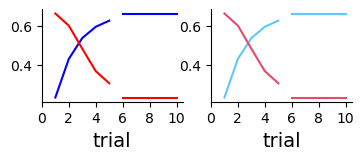

In [14]:
# now we want to plot the cue response in each condition

# t1 is the cue response == 1s

block2 = 50
block3 = 100
block4 = 150
block5 = 200

c3 = np.array([92,201,250])/255
c4 = np.array([234,72,105])/255

shortcue_early = (rpe1[block3:(block3+5),t_cue] + rpe2[block4:(block4+5),t_cue])/2
shortcue_late = (rpe1[(block3+45):block4,t_cue] + rpe2[(block4+45):block5,t_cue])/2
longcue_early = (rpe1[block4:(block4+5),t_cue] + rpe2[block3:(block3+5),t_cue])/2
longcue_late = (rpe1[(block4+45):block5,t_cue] + rpe2[(block3+45):block4,t_cue])/2

shortflavorcue_early = (rpe1[block5:(block5+5),t_cue] + rpe2[block2:(block2+5),t_cue])/2
shortflavorcue_late = (rpe1[(block5+45):(block5+50),t_cue] + rpe2[(block2+45):block3,t_cue])/2
longflavorcue_early = (rpe1[block2:(block2+5),t_cue] + rpe2[block5:(block5+5),t_cue])/2
longflavorcue_late = (rpe1[(block2+45):block3,t_cue] + rpe2[(block5+45):(block5+50),t_cue])/2

fig,ax = plt.subplots(1,2,figsize=[4,1.2])

ax[0].plot(np.arange(1,6),shortcue_early,color='blue')
ax[0].plot(np.arange(6,11),shortcue_late,color='blue')
ax[0].plot(np.arange(1,6),longcue_early,color='red')
ax[0].plot(np.arange(6,11),longcue_late,color='red')
ax[0].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)

ax[1].plot(np.arange(1,6),shortflavorcue_early,color=c3)
ax[1].plot(np.arange(6,11),shortflavorcue_late,color=c3)
ax[1].plot(np.arange(1,6),longflavorcue_early,color=c4)
ax[1].plot(np.arange(6,11),longflavorcue_late,color=c4)
ax[1].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)

sns.despine()


# plt.savefig('Figure5a_classicTD_noreset_cueresponse.png', bbox_inches="tight")


## Figure 5b. TD($\lambda$) global reset


(0.0, 1.0, 0.0, 1.0)

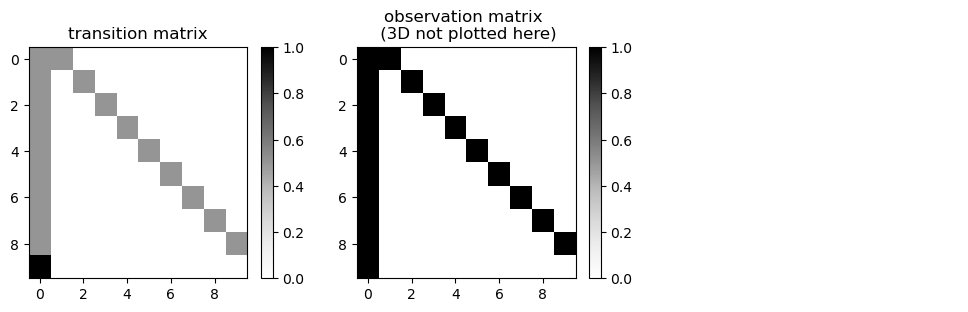

In [15]:

nstates = int(d_max) + 1 # timepoint states for cued states and single ITI state
model = 2
nids = 1

# build transition matrix
T = models.createTransitionMatrix(nstates,model,nids)

# build 3D observation matrix
O = models.createObservationMatrix3D(nstates,model,nids)

# we need to map states to taskstates for the eligibility reset
# again, nid=1 is straightforward
taskstates = np.zeros([nstates,2],dtype='bool')
taskstates[0,0] = True
taskstates[1:,1] = True

# map observations to reward amount
reward = np.zeros(O.shape[1])
reward[2:] = 1

# plot these to check
fig,ax = plt.subplots(1,3,figsize=[12,3])
ax.ravel()

c1 = ax[0].imshow(T[np.append(np.arange(0,9),T.shape[0]-1),:10],aspect='auto',cmap='Greys')

ax[0].set_title('transition matrix')
fig.colorbar(c1, ax=ax[0])

c2 = ax[1].imshow(O[np.append(np.arange(0,9),T.shape[0]-1),:10,:].sum(axis=2),aspect='auto',cmap='Greys')
ax[1].set_title('observation matrix \n (3D not plotted here)')
fig.colorbar(c2, ax=ax[1])


# ax[1].axis('off')
ax[2].axis('off')



# plt.savefig('Figure5b_classicTD_reset_transition.png')



In [16]:
# now we can compute TD learning over this structure

eta = 0.4
gamma = 0.95
elambda = 1
decay = 0.1

state1, nextstate1, w1, elig1, v1, nextv1, rpe1, thread1 = models.TDlambda(well1, T, O, taskstates, reward, eta, gamma, elambda, decay)


In [17]:
# and the second well
state2, nextstate2, w2, elig2, v2, nextv2, rpe2, thread2 = models.TDlambda(well2, T, O, taskstates, reward, eta, gamma, elambda, decay)


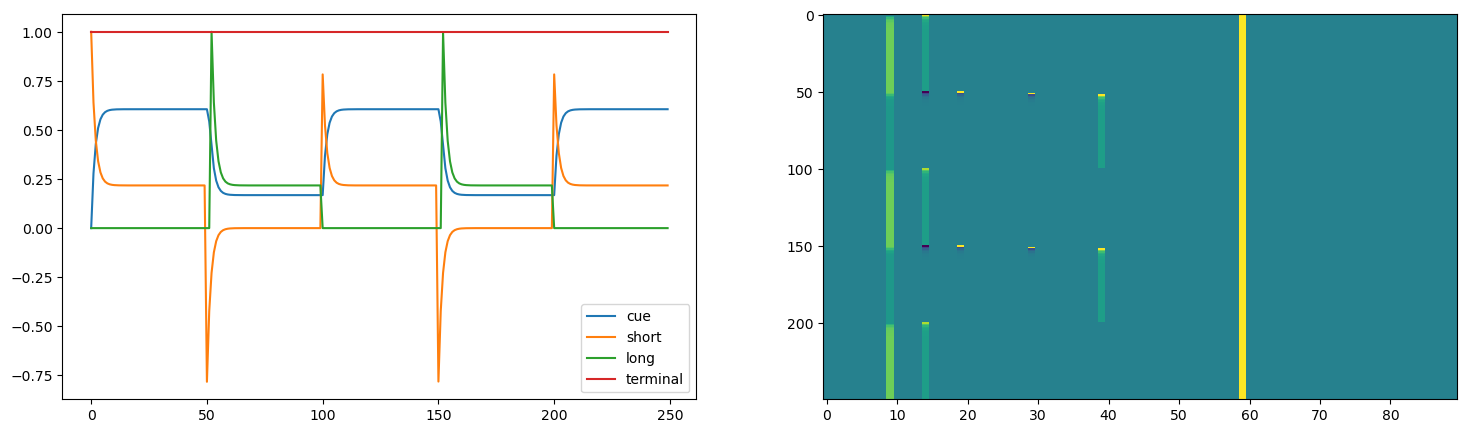

In [18]:
# RPE through task


fig,ax = plt.subplots(1,2,figsize=[18,5])

ax[0].plot(rpe1[:,[t_cue,t_short,t_long,t_terminal]])
ax[0].legend(['cue','short','long','terminal'],loc="lower right")

ax[1].imshow(rpe1,aspect='auto',interpolation='nearest')



(0.0, 1.0, 0.0, 1.0)

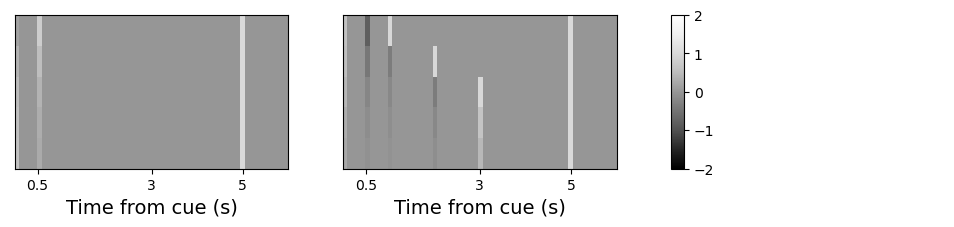

In [19]:
# rpe at block changes (combined)

fig,ax = plt.subplots(1,3,figsize=[12,2])

# tr_index[]

shortsame = (rpe1[tr_index[0,2,:],:] + rpe2[(blocktr*3):(blocktr*3+5),:])/2
longsame = (rpe1[tr_index[0,3,:],:] + rpe2[(blocktr*2):(blocktr*2+5),:])/2
shortdiff = (rpe1[(blocktr*4):(blocktr*4+5),:] + rpe2[(blocktr):(blocktr+5),:])/2
longdiff = (rpe1[(blocktr):(blocktr+5),:] + rpe2[(blocktr*4):(blocktr*4+5),:])/2

cbar = ax[0].imshow((shortsame+shortdiff)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow((longsame+longdiff)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("left", size="5%", pad=0.05)
fig.colorbar(cbar,ax=ax[2],cax=cax)

ax[2].axis('off')

# plt.savefig('Figure5a_classicTD_reset_RPE.png', bbox_inches="tight")



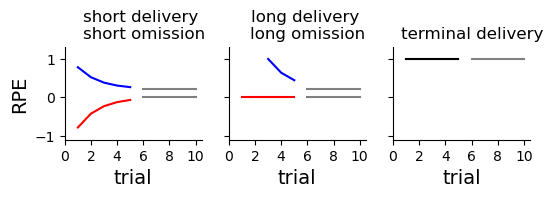

In [20]:
# rpe through block across wells

fig,ax = plt.subplots(1,3,figsize=[6,1.2])

shortdel1a = rpe1[tr_index[:,2,:].flatten(),t_short]
shortdel1b = rpe1[tr_index[:,4,:].flatten(),t_short]
shortdel2a = rpe2[tr_index[:,3,:].flatten(),t_short]
shortdel2b = rpe2[tr_index[:,1,:].flatten(),t_short]
shortdelivery_early = (shortdel1a[:ntr] + shortdel1b[:ntr] + shortdel2a[:ntr] + shortdel2b[:ntr])/4
shortdelivery_late = (shortdel1a[ntr:] + shortdel1b[ntr:] + shortdel2a[ntr:] + shortdel2b[ntr:])/4

longdel1a = rpe1[tr_index[:,3,:].flatten(),t_long]
longdel1b = rpe1[tr_index[:,1,:].flatten(),t_long]
longdel2a = rpe2[tr_index[:,2,:].flatten(),t_long]
longdel2b = rpe2[tr_index[:,4,:].flatten(),t_long]
longdelivery_early = (longdel1a[2:ntr] + longdel1b[2:ntr] + longdel2a[2:ntr] + longdel2b[2:ntr])/4
longdelivery_late = (longdel1a[ntr:] + longdel1b[ntr:] + longdel2a[ntr:] + longdel2b[ntr:])/4

shortom1a = rpe1[tr_index[:,3,:].flatten(),t_short]
shortom1b = rpe1[tr_index[:,1,:].flatten(),t_short]
shortom2a = rpe2[tr_index[:,2,:].flatten(),t_short]
shortom2b = rpe2[tr_index[:,4,:].flatten(),t_short]
shortomission_early = (shortom1a[:ntr] + shortom1b[:ntr] + shortom2a[:ntr] + shortom2b[:ntr])/4
shortomission_late = (shortom1a[ntr:] + shortom1b[ntr:] + shortom2a[ntr:] + shortom2b[ntr:])/4

longom1a = rpe1[tr_index[:,2,:].flatten(),t_long]
longom1b = rpe1[tr_index[:,4,:].flatten(),t_long]
longom2a = rpe2[tr_index[:,3,:].flatten(),t_long]
longom2b = rpe2[tr_index[:,1,:].flatten(),t_long]
longomission_early = (longom1a[:ntr] + longom1b[:ntr] + longom2a[:ntr] + longom2b[:ntr])/4
longomission_late = (longom1a[ntr:] + longom1b[ntr:] + longom2a[ntr:] + longom2b[ntr:])/4

terminal1a_short = rpe1[tr_index[:,2,:].flatten(),t_terminal]
terminal1b_short = rpe1[tr_index[:,4,:].flatten(),t_terminal]
terminal2a_short = rpe2[tr_index[:,3,:].flatten(),t_terminal]
terminal2b_short = rpe2[tr_index[:,1,:].flatten(),t_terminal]
terminal1a_long = rpe1[tr_index[:,3,:].flatten(),t_terminal]
terminal1b_long = rpe1[tr_index[:,1,:].flatten(),t_terminal]
terminal2a_long = rpe2[tr_index[:,2,:].flatten(),t_terminal]
terminal2b_long = rpe2[tr_index[:,4,:].flatten(),t_terminal]

terminaldelivery_early = (terminal1a_short[:ntr] + terminal1b_short[:ntr] + terminal2a_short[:ntr] + terminal2b_short[:ntr] +\
                    terminal1a_long[:ntr] + terminal1b_long[:ntr] + terminal2a_long[:ntr] + terminal2b_long[:ntr])/8
terminaldelivery_late = (terminal1a_short[ntr:] + terminal1b_short[ntr:] + terminal2a_short[ntr:] + terminal2b_short[ntr:] +\
                    terminal1a_long[ntr:] + terminal1b_long[ntr:] + terminal2a_long[ntr:] + terminal2b_long[ntr:])/8

ax[0].plot(np.arange(1,6),shortdelivery_early,color='blue')
ax[0].plot(np.arange(6,11),shortdelivery_late,color='Grey')
ax[0].plot(np.arange(1,6),shortomission_early,color='red')
ax[0].plot(np.arange(6,11),shortomission_late,color='Grey')
ax[0].set(ylabel='RPE',xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),ylim=[-1.1,1.3])
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)
ax[0].set_title("    short delivery \n    short omission",fontsize=12)

ax[1].plot(np.arange(3,6),longdelivery_early,color='blue')
ax[1].plot(np.arange(6,11),longdelivery_late,color='Grey')
ax[1].plot(np.arange(1,6),longomission_early,color='red')
ax[1].plot(np.arange(6,11),longomission_late,color='grey')
ax[1].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.1,1.3])
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)
# ax[1].plot(0,rpe[blocktr*3,t_late1],color='red',marker='.')
# ax[1].plot(1,rpe[blocktr*3+1,t_late2],color='red',marker='.')
ax[1].set_title("    long delivery \n    long omission",fontsize=12)

ax[2].plot(np.arange(1,6),terminaldelivery_early,color='k')
ax[2].plot(np.arange(6,11),terminaldelivery_late,color='grey')
ax[2].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.1,1.3])
ax[2].xaxis.label.set_fontsize(xfont)
ax[2].yaxis.label.set_fontsize(xfont)
ax[2].set_title('    terminal delivery',fontsize=12)


sns.despine()


# plt.savefig('Figure5a_classicTD_reset_features.png', bbox_inches="tight")



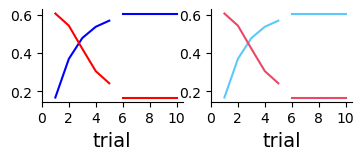

In [21]:
# cue response

shortcue_early = (rpe1[block3:(block3+5),t_cue] + rpe2[block4:(block4+5),t_cue])/2
shortcue_late = (rpe1[(block3+45):block4,t_cue] + rpe2[(block4+45):block5,t_cue])/2
longcue_early = (rpe1[block4:(block4+5),t_cue] + rpe2[block3:(block3+5),t_cue])/2
longcue_late = (rpe1[(block4+45):block5,t_cue] + rpe2[(block3+45):block4,t_cue])/2

shortflavorcue_early = (rpe1[block5:(block5+5),t_cue] + rpe2[block2:(block2+5),t_cue])/2
shortflavorcue_late = (rpe1[(block5+45):(block5+50),t_cue] + rpe2[(block2+45):block3,t_cue])/2
longflavorcue_early = (rpe1[block2:(block2+5),t_cue] + rpe2[block5:(block5+5),t_cue])/2
longflavorcue_late = (rpe1[(block2+45):block3,t_cue] + rpe2[(block5+45):(block5+50),t_cue])/2

fig,ax = plt.subplots(1,2,figsize=[4,1.2])

ax[0].plot(np.arange(1,6),shortcue_early,color='blue')
ax[0].plot(np.arange(6,11),shortcue_late,color='blue')
ax[0].plot(np.arange(1,6),longcue_early,color='red')
ax[0].plot(np.arange(6,11),longcue_late,color='red')
ax[0].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)

ax[1].plot(np.arange(1,6),shortflavorcue_early,color=c3)
ax[1].plot(np.arange(6,11),shortflavorcue_late,color=c3)
ax[1].plot(np.arange(1,6),longflavorcue_early,color=c4)
ax[1].plot(np.arange(6,11),longflavorcue_late,color=c4)
ax[1].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)

sns.despine()



# plt.savefig('Figure5a_classicTD_globalreset_cueresponse.png', bbox_inches="tight")

## Figure 5c. TD($\lambda$) sequence reset

(0.0, 1.0, 0.0, 1.0)

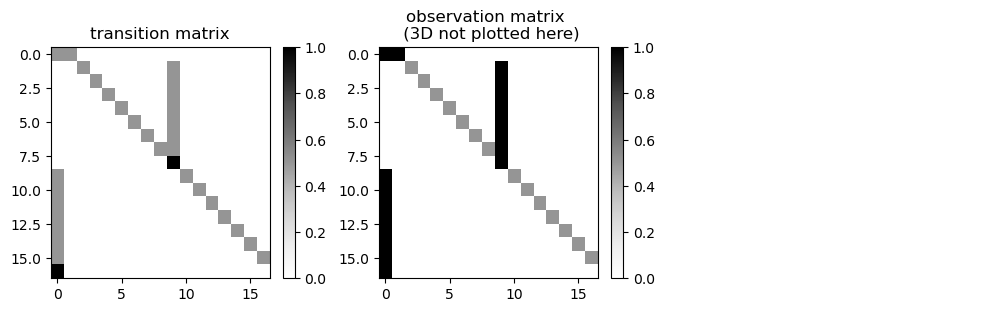

In [22]:
importlib.reload(models)


nstates = int(d_max) + 1 # timepoint states for cued states and single ITI state
model = 3
nids = 2 # first reward/second reward

# build transition matrix
T = models.createTransitionMatrix(nstates,model,nids)

# build 3D observation matrix
O = models.createObservationMatrix3D(nstates,model,nids)

# we need to map states to higher-level task states
# each sequential thread will be a separate taskstate (nid=2)
taskstates = np.zeros([T.shape[0],3],dtype='bool')
taskstates[0,0] = True
taskstates[1:(nstates-1),1] = True
taskstates[nstates:,2] = True

# map observations to reward amount
reward = np.zeros(O.shape[1])
reward[2:] = 1

# plot these to check
fig,ax = plt.subplots(1,3,figsize=[12,3])
ax.ravel()


plotT = models.createTransitionMatrix(9,model,nids)
c1 = ax[0].imshow(plotT,aspect='auto',cmap='Greys')

ax[0].set_title('transition matrix')
fig.colorbar(c1, ax=ax[0])

plotO = models.createObservationMatrix3D(9,model,nids)
c2 = ax[1].imshow(plotO.sum(axis=2),aspect='auto',cmap='Greys')
ax[1].set_title('observation matrix \n (3D not plotted here)')
fig.colorbar(c2, ax=ax[1])

ax[2].axis('off')

In [23]:
# now we can compute TD learning over this structure 

eta = 0.4
gamma = 0.95
elambda = 1
decay = 0.1


state1, nextstate1, w1, elig1, v1, nextv1, rpe1, thread1 = models.TDlambda(well1, T, O, taskstates, reward, eta, gamma, elambda, decay)


In [24]:
# and the second well
state2, nextstate2, w2, elig2, v2, nextv2, rpe2, thread2 = models.TDlambda(well2, T, O, taskstates, reward, eta, gamma, elambda, decay)



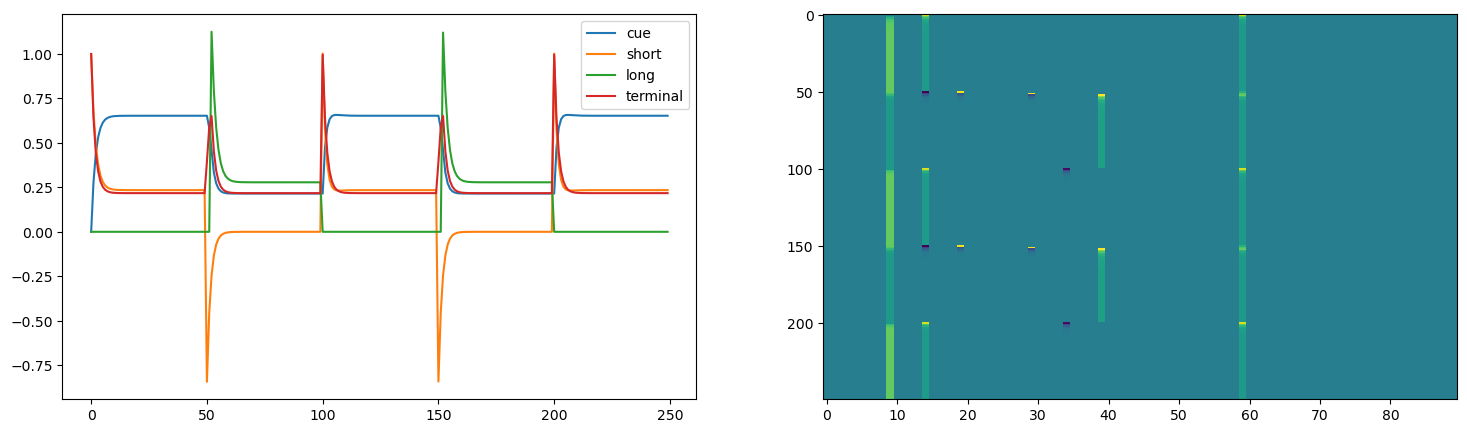

In [25]:
# RPE through task


fig,ax = plt.subplots(1,2,figsize=[18,5])

ax[0].plot(rpe1[:,[t_cue,t_short,t_long,t_terminal]])
ax[0].legend(['cue','short','long','terminal'])

ax[1].imshow(rpe1,aspect='auto',interpolation='nearest')

Text(0.43, 0.98, 'well 1')

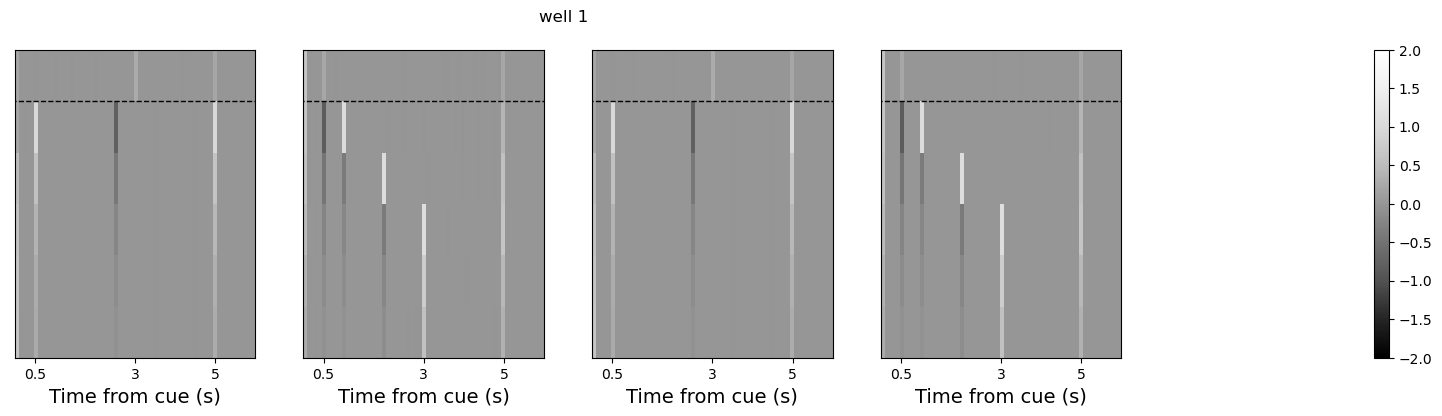

In [26]:
# well 1

colors = ["darkblue","blue", "lightgray", "red","darkred"]
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors)
cmap2 = "Greys_r"

well1_shortsame = np.arange((blocktr*2-1),(blocktr*2+5))
well1_longsame = np.arange((blocktr*3-1),(blocktr*3+5))
well1_shortdiff = np.arange((blocktr*4-1),(blocktr*4+5))
well1_longdiff = np.arange((blocktr-1),(blocktr+5))

fig,ax = plt.subplots(1,5,figsize=[18,4])

cbar = ax[0].imshow(rpe1[well1_shortsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(rpe1[well1_longsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(rpe1[well1_shortdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[2].set(xlim=[1,xlim+1])
ax[2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(rpe1[well1_longdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[3].set(xlim=[1,xlim+1])
ax[3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[4].axis('off')

fig.colorbar(cbar,ax=ax[4])

fig.suptitle('well 1',x=0.43)




Text(0.43, 0.98, 'well 2')

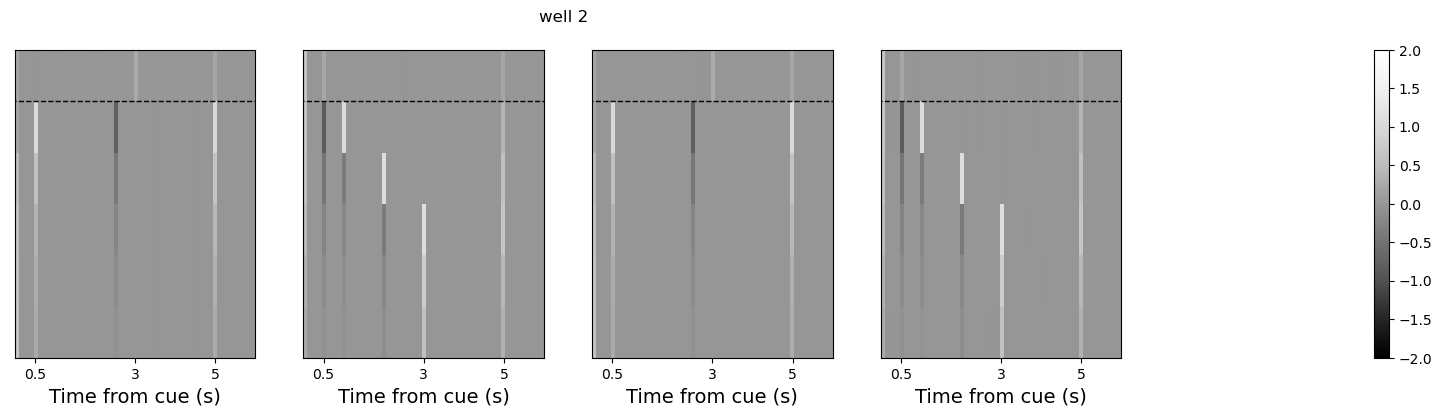

In [27]:
# well 2

well2_shortsame = np.arange((blocktr*3-1),(blocktr*3+5))
well2_longsame = np.arange((blocktr*2-1),(blocktr*2+5))
well2_shortdiff = np.arange((blocktr-1),(blocktr+5))
well2_longdiff = np.arange((blocktr*4-1),(blocktr*4+5))

fig,ax = plt.subplots(1,5,figsize=[18,4])

cbar = ax[0].imshow(rpe2[well2_shortsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(rpe2[well2_longsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(rpe2[well2_shortdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[2].set(xlim=[1,xlim+1])
ax[2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(rpe2[well2_longdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[3].set(xlim=[1,xlim+1])
ax[3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[4].axis('off')

fig.colorbar(cbar,ax=ax[4])


fig.suptitle('well 2',x=0.43)




(0.0, 1.0, 0.0, 1.0)

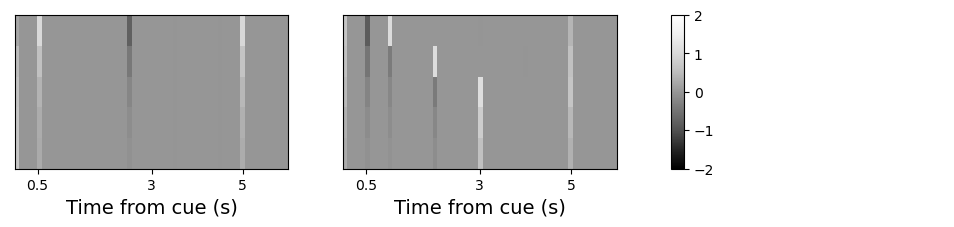

In [28]:
# rpe at block changes 


fig,ax = plt.subplots(1,3,figsize=[12,2])


shortsame = (rpe1[(blocktr*2):(blocktr*2+5),:] + rpe2[(blocktr*3):(blocktr*3+5),:])/2
longsame = (rpe1[(blocktr*3):(blocktr*3+5),:] + rpe2[(blocktr*2):(blocktr*2+5),:])/2
shortdiff = (rpe1[(blocktr*4):(blocktr*4+5),:] + rpe2[(blocktr):(blocktr+5),:])/2
longdiff = (rpe1[(blocktr):(blocktr+5),:] + rpe2[(blocktr*4):(blocktr*4+5),:])/2

cbar = ax[0].imshow((shortsame+shortdiff)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow((longsame+longdiff)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("left", size="5%", pad=0.05)
fig.colorbar(cbar,ax=ax[2],cax=cax)

ax[2].axis('off')

# plt.savefig('Figure5a_classicTD_sequence_RPE.png', bbox_inches="tight")




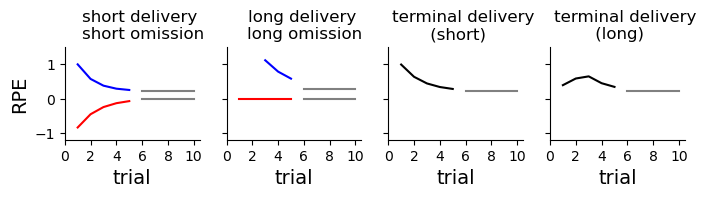

In [29]:
# rpe through block across wells

fig,ax = plt.subplots(1,4,figsize=[8,1.2])


shortdel1a = rpe1[tr_index[:,2,:].flatten(),t_short]
shortdel1b = rpe1[tr_index[:,4,:].flatten(),t_short]
shortdel2a = rpe2[tr_index[:,3,:].flatten(),t_short]
shortdel2b = rpe2[tr_index[:,1,:].flatten(),t_short]
shortdelivery_early = (shortdel1a[:ntr] + shortdel1b[:ntr] + shortdel2a[:ntr] + shortdel2b[:ntr])/4
shortdelivery_late = (shortdel1a[ntr:] + shortdel1b[ntr:] + shortdel2a[ntr:] + shortdel2b[ntr:])/4

longdel1a = rpe1[tr_index[:,3,:].flatten(),t_long]
longdel1b = rpe1[tr_index[:,1,:].flatten(),t_long]
longdel2a = rpe2[tr_index[:,2,:].flatten(),t_long]
longdel2b = rpe2[tr_index[:,4,:].flatten(),t_long]
longdelivery_early = (longdel1a[2:ntr] + longdel1b[2:ntr] + longdel2a[2:ntr] + longdel2b[2:ntr])/4
longdelivery_late = (longdel1a[ntr:] + longdel1b[ntr:] + longdel2a[ntr:] + longdel2b[ntr:])/4

shortom1a = rpe1[tr_index[:,3,:].flatten(),t_short]
shortom1b = rpe1[tr_index[:,1,:].flatten(),t_short]
shortom2a = rpe2[tr_index[:,2,:].flatten(),t_short]
shortom2b = rpe2[tr_index[:,4,:].flatten(),t_short]
shortomission_early = (shortom1a[:ntr] + shortom1b[:ntr] + shortom2a[:ntr] + shortom2b[:ntr])/4
shortomission_late = (shortom1a[ntr:] + shortom1b[ntr:] + shortom2a[ntr:] + shortom2b[ntr:])/4

longom1a = rpe1[tr_index[:,2,:].flatten(),t_long]
longom1b = rpe1[tr_index[:,4,:].flatten(),t_long]
longom2a = rpe2[tr_index[:,3,:].flatten(),t_long]
longom2b = rpe2[tr_index[:,1,:].flatten(),t_long]
longomission_early = (longom1a[:ntr] + longom1b[:ntr] + longom2a[:ntr] + longom2b[:ntr])/4
longomission_late = (longom1a[ntr:] + longom1b[ntr:] + longom2a[ntr:] + longom2b[ntr:])/4

terminal1a_short = rpe1[tr_index[:,2,:].flatten(),t_terminal]
terminal1b_short = rpe1[tr_index[:,4,:].flatten(),t_terminal]
terminal2a_short = rpe2[tr_index[:,3,:].flatten(),t_terminal]
terminal2b_short = rpe2[tr_index[:,1,:].flatten(),t_terminal]
terminal1a_long = rpe1[tr_index[:,3,:].flatten(),t_terminal]
terminal1b_long = rpe1[tr_index[:,1,:].flatten(),t_terminal]
terminal2a_long = rpe2[tr_index[:,2,:].flatten(),t_terminal]
terminal2b_long = rpe2[tr_index[:,4,:].flatten(),t_terminal]

terminaldelivery_early = (terminal1a_short[:ntr] + terminal1b_short[:ntr] + terminal2a_short[:ntr] + terminal2b_short[:ntr] +\
                    terminal1a_long[:ntr] + terminal1b_long[:ntr] + terminal2a_long[:ntr] + terminal2b_long[:ntr])/8
terminaldelivery_late = (terminal1a_short[ntr:] + terminal1b_short[ntr:] + terminal2a_short[ntr:] + terminal2b_short[ntr:] +\
                    terminal1a_long[ntr:] + terminal1b_long[ntr:] + terminal2a_long[ntr:] + terminal2b_long[ntr:])/8


shortterminal_early = (terminal1a_short[:ntr] + terminal1b_short[:ntr] + terminal2a_short[:ntr] + terminal2b_short[:ntr])/4
shortterminal_late = (terminal1a_short[ntr:] + terminal1b_short[ntr:] + terminal2a_short[ntr:] + terminal2b_short[ntr:])/4
longterminal_early = (terminal1a_long[:ntr] + terminal1b_long[:ntr] + terminal2a_long[:ntr] + terminal2b_long[:ntr])/4
longterminal_late = (terminal1a_long[ntr:] + terminal1b_long[ntr:] + terminal2a_long[ntr:] + terminal2b_long[ntr:])/4


ax[0].plot(np.arange(1,6),shortdelivery_early,color='blue')
ax[0].plot(np.arange(6,11),shortdelivery_late,color='Grey')
ax[0].plot(np.arange(1,6),shortomission_early,color='red')
ax[0].plot(np.arange(6,11),shortomission_late,color='Grey')
ax[0].set(ylabel='RPE',xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),ylim=[-1.2,1.5])
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)
ax[0].set_title("    short delivery \n    short omission",fontsize=12)

ax[1].plot(np.arange(3,6),longdelivery_early,color='blue')
ax[1].plot(np.arange(6,11),longdelivery_late,color='Grey')
ax[1].plot(np.arange(1,6),longomission_early,color='red')
ax[1].plot(np.arange(6,11),longomission_late,color='grey')
ax[1].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.2,1.5])
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)
# ax[1].plot(0,rpe[blocktr*3,t_late1],color='red',marker='.')
# ax[1].plot(1,rpe[blocktr*3+1,t_late2],color='red',marker='.')
ax[1].set_title("    long delivery \n    long omission",fontsize=12)

ax[2].plot(np.arange(1,6),shortterminal_early,color='k')
ax[2].plot(np.arange(6,11),shortterminal_late,color='grey')
ax[2].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.2,1.5])
ax[2].xaxis.label.set_fontsize(xfont)
ax[2].yaxis.label.set_fontsize(xfont)
ax[2].set_title('    terminal delivery \n (short)',fontsize=12)

ax[3].plot(np.arange(1,6),longterminal_early,color='k')
ax[3].plot(np.arange(6,11),longterminal_late,color='grey')
ax[3].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.2,1.5])
ax[3].xaxis.label.set_fontsize(xfont)
ax[3].yaxis.label.set_fontsize(xfont)
ax[3].set_title('    terminal delivery \n (long)',fontsize=12)

sns.despine()


# plt.savefig('Figure5a_classicTD_sequence_features.png', bbox_inches="tight")



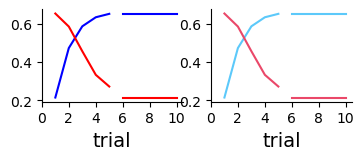

In [30]:
# cue response

shortcue_early = (rpe1[block3:(block3+5),t_cue] + rpe2[block4:(block4+5),t_cue])/2
shortcue_late = (rpe1[(block3+45):block4,t_cue] + rpe2[(block4+45):block5,t_cue])/2
longcue_early = (rpe1[block4:(block4+5),t_cue] + rpe2[block3:(block3+5),t_cue])/2
longcue_late = (rpe1[(block4+45):block5,t_cue] + rpe2[(block3+45):block4,t_cue])/2

shortflavorcue_early = (rpe1[block5:(block5+5),t_cue] + rpe2[block2:(block2+5),t_cue])/2
shortflavorcue_late = (rpe1[(block5+45):(block5+50),t_cue] + rpe2[(block2+45):block3,t_cue])/2
longflavorcue_early = (rpe1[block2:(block2+5),t_cue] + rpe2[block5:(block5+5),t_cue])/2
longflavorcue_late = (rpe1[(block2+45):block3,t_cue] + rpe2[(block5+45):(block5+50),t_cue])/2

fig,ax = plt.subplots(1,2,figsize=[4,1.2])

ax[0].plot(np.arange(1,6),shortcue_early,color='blue')
ax[0].plot(np.arange(6,11),shortcue_late,color='blue')
ax[0].plot(np.arange(1,6),longcue_early,color='red')
ax[0].plot(np.arange(6,11),longcue_late,color='red')
ax[0].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)

ax[1].plot(np.arange(1,6),shortflavorcue_early,color=c3)
ax[1].plot(np.arange(6,11),shortflavorcue_late,color=c3)
ax[1].plot(np.arange(1,6),longflavorcue_early,color=c4)
ax[1].plot(np.arange(6,11),longflavorcue_late,color=c4)
ax[1].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)

sns.despine()


# plt.savefig('Figure5a_classicTD_sequencereset_cueresponse.png', bbox_inches="tight")

## Figure 5d. TD($\lambda$) delay-specific sequential reset


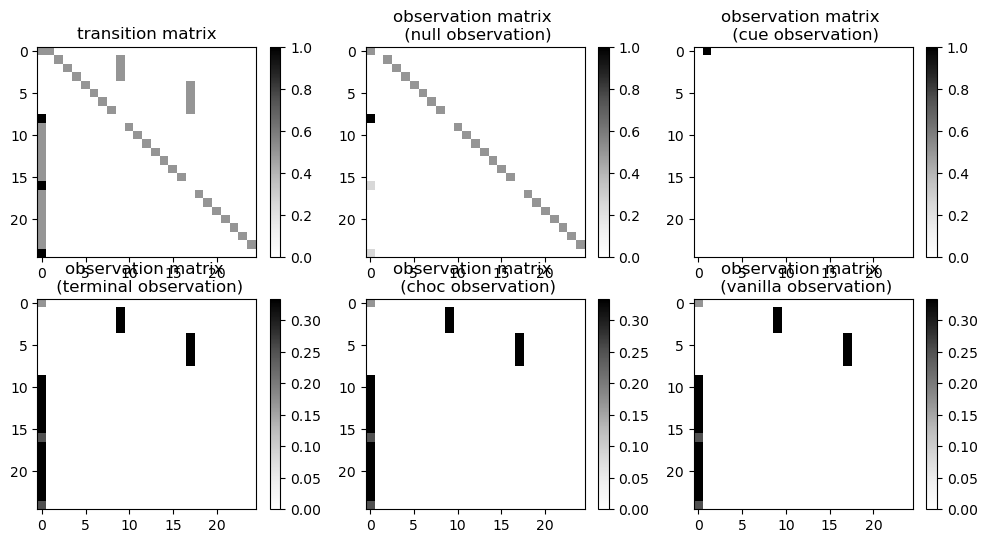

In [31]:
importlib.reload(models)


nstates = int(d_max) + 1 # timepoint states for cued states and single ITI state
model = 4
nids = 3 # first reward/short second reward/long second reward
bisect = 7 # after short=0.5; 12 == after 1s long reward

# we will construct the sequential threads with nstates per thread
threads = [[0],np.arange(1,d_max+1),np.arange(d_max+1,d_max*2+1),np.arange(d_max*2+1,d_max*3+1)]

# return full world model
T,O,taskstates = models.buildWorldModel(model,threads,bisect)


# map observations to reward amount
reward = np.zeros(O.shape[1])
reward[2:] = 1

# plot these to check
nplot = 8
plotthreads = [[0],np.arange(1,nplot+1),np.arange(nplot+1,nplot*2+1),np.arange(nplot*2+1,nplot*3+1)]

plotT,plotO,plotTask = models.buildWorldModel(model,plotthreads,3)

fig,ax = plt.subplots(2,3,figsize=[12,6])
ax = ax.ravel()

c1 = ax[0].imshow(plotT,aspect='auto',cmap='Greys',interpolation='nearest')

ax[0].set_title('transition matrix')
fig.colorbar(c1, ax=ax[0])

c2 = ax[1].imshow(plotO[:,:,0],aspect='auto',cmap='Greys',interpolation='nearest')
ax[1].set_title('observation matrix \n (null observation)')
fig.colorbar(c2, ax=ax[1])

c3 = ax[2].imshow(plotO[:,:,1],aspect='auto',cmap='Greys',interpolation='nearest')
ax[2].set_title('observation matrix \n (cue observation)')
fig.colorbar(c3, ax=ax[2])

c4 = ax[3].imshow(plotO[:,:,2],aspect='auto',cmap='Greys',interpolation='nearest')
ax[3].set_title('observation matrix \n (terminal observation)')
fig.colorbar(c4, ax=ax[3])

c5 = ax[4].imshow(plotO[:,:,3],aspect='auto',cmap='Greys',interpolation='nearest')
ax[4].set_title('observation matrix \n (choc observation)')
fig.colorbar(c5, ax=ax[4])

c6 = ax[5].imshow(plotO[:,:,4],aspect='auto',cmap='Greys',interpolation='nearest')
ax[5].set_title('observation matrix \n (vanilla observation)')
fig.colorbar(c6, ax=ax[5])




In [32]:
importlib.reload(models)

eta = 0.4
gamma = 0.95
elambda = 1
decay = 0.1 # 0.1


state1, nextstate1, w1, elig1, v1, nextv1, rpe1, thread1 = models.TDlambda(well1, T, O, taskstates, reward, eta, gamma, elambda, decay) 



In [33]:
# and the second well
state2, nextstate2, w2, elig2, v2, nextv2, rpe2, thread2 = models.TDlambda(well2, T, O, taskstates, reward, eta, gamma, elambda, decay)


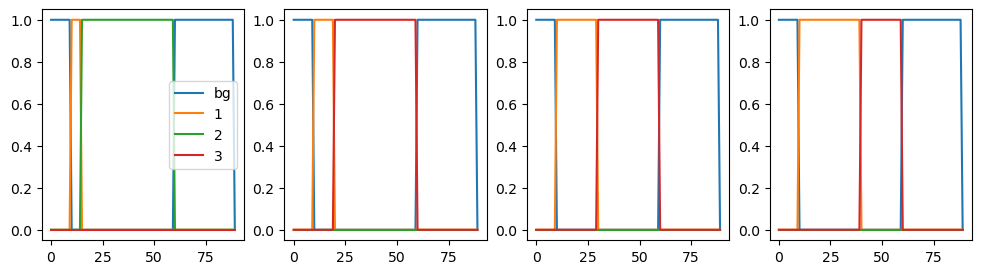

In [34]:
# check state trajectories using the taskstates mapping

tr = 49

fig,ax = plt.subplots(1,4,figsize=[12,3])

ax[0].plot((np.squeeze(state1[tr,:,:]).T)@taskstates)
ax[0].legend(['bg','1','2','3'])
ax[1].plot(thread1[50,:,:].T)
ax[2].plot(thread1[51,:,:].T)
ax[3].plot(thread1[52,:,:].T)
# ax[0].plot(thread1[tr,:,:].T,linestyle='--')

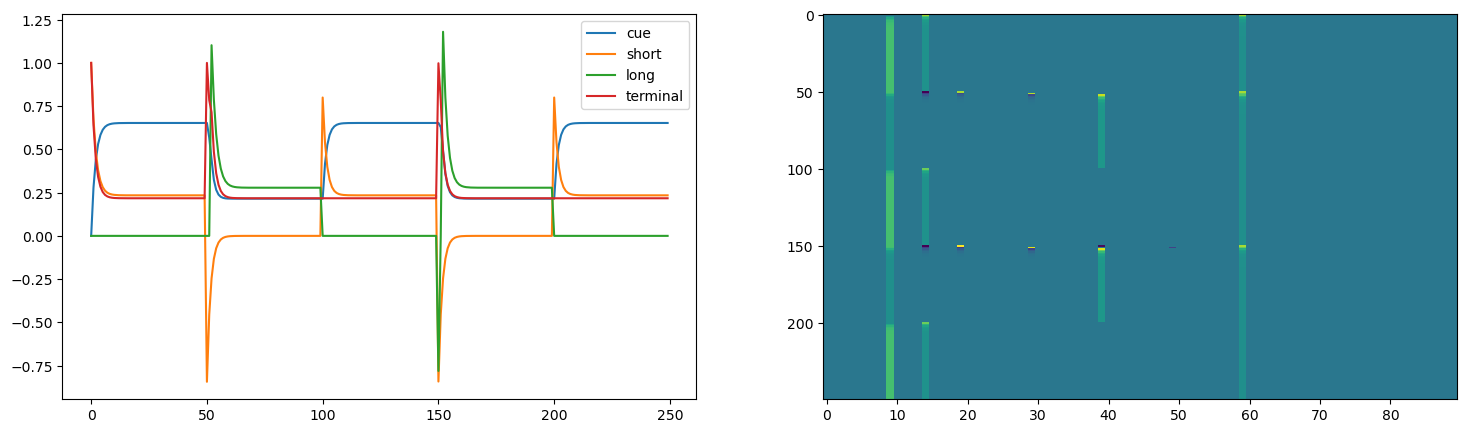

In [35]:
# RPE through task

fig,ax = plt.subplots(1,2,figsize=[18,5])

ax[0].plot(rpe1[:,[t_cue,t_short,t_long,t_terminal]])
ax[0].legend(['cue','short','long','terminal'])

ax[1].imshow(rpe1,aspect='auto',interpolation='nearest')

Text(0.43, 0.98, 'well 1')

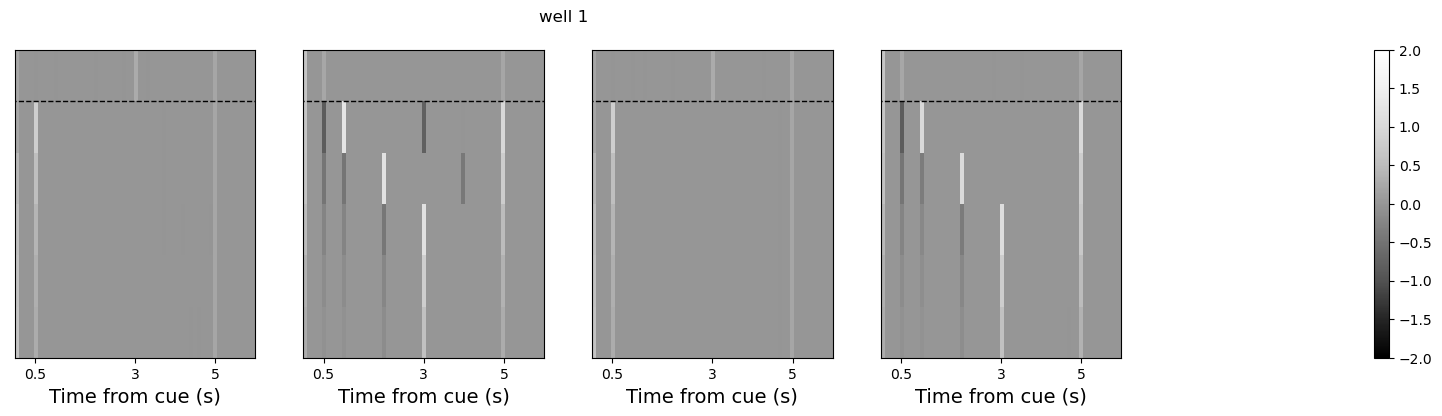

In [36]:
# well 1

colors = ["darkblue","blue", "lightgray", "red","darkred"]
cmap2 = LinearSegmentedColormap.from_list("mycmap", colors)
cmap2 = "Greys_r"

well1_shortsame = np.arange((blocktr*2-1),(blocktr*2+5))
well1_longsame = np.arange((blocktr*3-1),(blocktr*3+5))
well1_shortdiff = np.arange((blocktr*4-1),(blocktr*4+5))
well1_longdiff = np.arange((blocktr-1),(blocktr+5))

fig,ax = plt.subplots(1,5,figsize=[18,4])

cbar = ax[0].imshow(rpe1[well1_shortsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(rpe1[well1_longsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(rpe1[well1_shortdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[2].set(xlim=[1,xlim+1])
ax[2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(rpe1[well1_longdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[3].set(xlim=[1,xlim+1])
ax[3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[4].axis('off')

fig.colorbar(cbar,ax=ax[4])

fig.suptitle('well 1',x=0.43)



Text(0.43, 0.98, 'well 2')

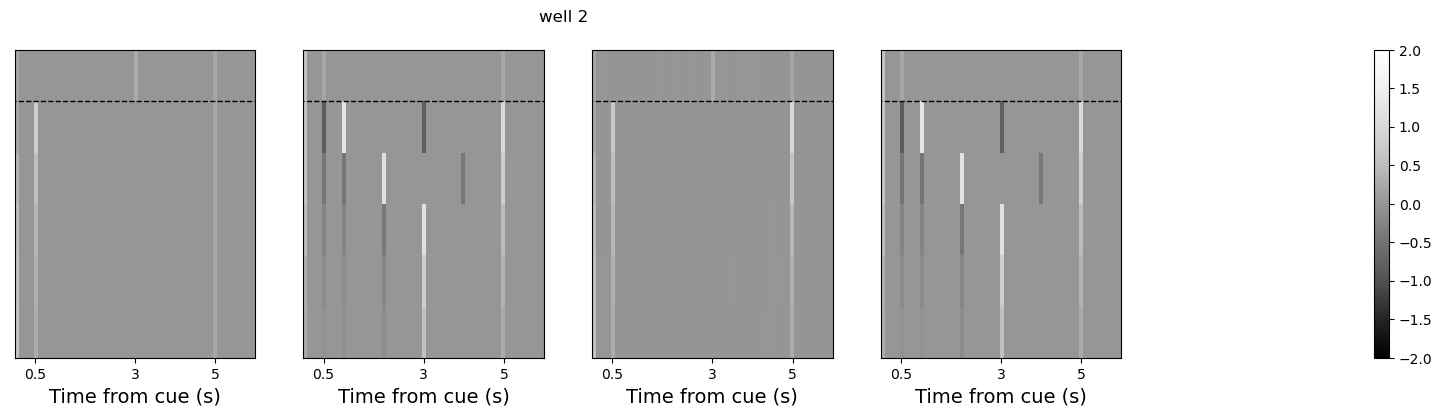

In [37]:
# well 2

well2_shortsame = np.arange((blocktr*3-1),(blocktr*3+5))
well2_longsame = np.arange((blocktr*2-1),(blocktr*2+5))
well2_shortdiff = np.arange((blocktr-1),(blocktr+5))
well2_longdiff = np.arange((blocktr*4-1),(blocktr*4+5))

fig,ax = plt.subplots(1,5,figsize=[18,4])

cbar = ax[0].imshow(rpe2[well2_shortsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(rpe2[well2_longsame,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(rpe2[well2_shortdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[2].set(xlim=[1,xlim+1])
ax[2].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(rpe2[well2_longdiff,:],aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap2,vmin=-2,vmax=2)
ax[3].set(xlim=[1,xlim+1])
ax[3].plot([1-dt,7],[0.5,0.5],color='k',linewidth=1,linestyle='--')
ax[3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[4].axis('off')

fig.colorbar(cbar,ax=ax[4])


fig.suptitle('well 2',x=0.43)



(0.0, 1.0, 0.0, 1.0)

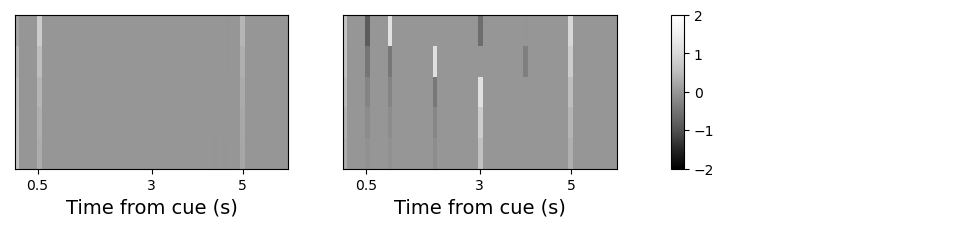

In [38]:
# rpe at block changes 


fig,ax = plt.subplots(1,3,figsize=[12,2])


shortsame = (rpe1[(blocktr*2):(blocktr*2+5),:] + rpe2[(blocktr*3):(blocktr*3+5),:])/2
longsame = (rpe1[(blocktr*3):(blocktr*3+5),:] + rpe2[(blocktr*2):(blocktr*2+5),:])/2
shortdiff = (rpe1[(blocktr*4):(blocktr*4+5),:] + rpe2[(blocktr):(blocktr+5),:])/2
longdiff = (rpe1[(blocktr):(blocktr+5),:] + rpe2[(blocktr*4):(blocktr*4+5),:])/2

cbar = ax[0].imshow((shortsame+shortdiff)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow((longsame+longdiff)/2,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

divider = make_axes_locatable(ax[2])
cax = divider.append_axes("left", size="5%", pad=0.05)
fig.colorbar(cbar,ax=ax[2],cax=cax)

ax[2].axis('off')

# plt.savefig('Figure5a_classicTD_temporalsequence_RPE.png', bbox_inches="tight")





(0.0, 1.0, 0.0, 1.0)

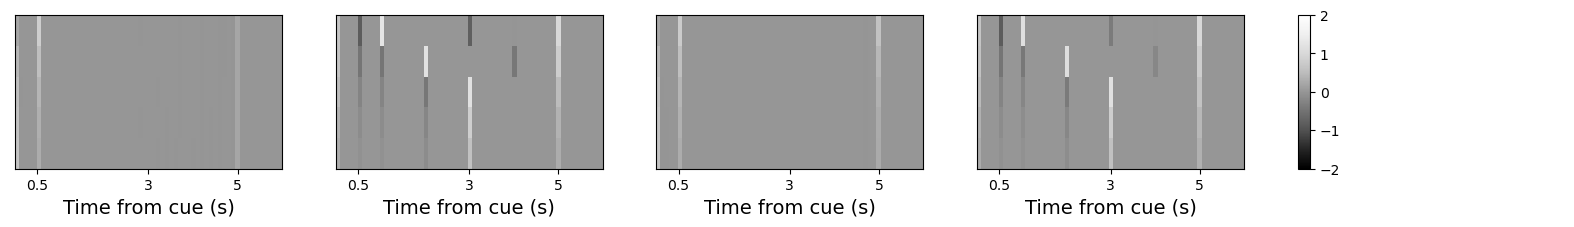

In [39]:
# rpe at block changes - delay and delay-flavor conditions


fig,ax = plt.subplots(1,5,figsize=[20,2])


shortsame = (rpe1[(blocktr*2):(blocktr*2+5),:] + rpe2[(blocktr*3):(blocktr*3+5),:])/2
longsame = (rpe1[(blocktr*3):(blocktr*3+5),:] + rpe2[(blocktr*2):(blocktr*2+5),:])/2
shortdiff = (rpe1[(blocktr*4):(blocktr*4+5),:] + rpe2[(blocktr):(blocktr+5),:])/2
longdiff = (rpe1[(blocktr):(blocktr+5),:] + rpe2[(blocktr*4):(blocktr*4+5),:])/2

cbar = ax[0].imshow(shortsame,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[0].set(xlim=[1,xlim+1])
ax[0].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[0].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[1].imshow(longsame,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[1].set(xlim=[1,xlim+1])
ax[1].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[1].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[2].imshow(shortdiff,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[2].set(xlim=[1,xlim+1])
ax[2].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[2].set_xlabel('Time from cue (s)',fontsize=xfont)

ax[3].imshow(longdiff,aspect='auto',interpolation='nearest',extent=[tpts[0]+dt,tpts[-1]+dt,5.5,-0.5],cmap=cmap,vmin=-2,vmax=2)
ax[3].set(xlim=[1,xlim+1])
ax[3].set(xticks=1+np.array([0.5,3,5]),xticklabels=['0.5','3','5'],yticks=[])
ax[3].set_xlabel('Time from cue (s)',fontsize=xfont)

divider = make_axes_locatable(ax[4])
cax = divider.append_axes("left", size="5%", pad=0.05)
fig.colorbar(cbar,ax=ax[2],cax=cax)

ax[4].axis('off')

# plt.savefig('Figure5a_classicTD_temporalsequence_4panel_RPE.png', bbox_inches="tight")




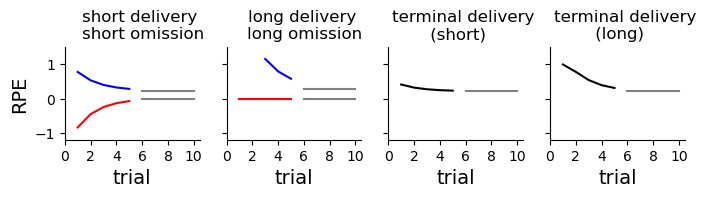

In [40]:
# rpe through block across wells

fig,ax = plt.subplots(1,4,figsize=[8,1.2])

shortdel1a = rpe1[tr_index[:,2,:].flatten(),t_short]
shortdel1b = rpe1[tr_index[:,4,:].flatten(),t_short]
shortdel2a = rpe2[tr_index[:,3,:].flatten(),t_short]
shortdel2b = rpe2[tr_index[:,1,:].flatten(),t_short]
shortdelivery_early = (shortdel1a[:ntr] + shortdel1b[:ntr] + shortdel2a[:ntr] + shortdel2b[:ntr])/4
shortdelivery_late = (shortdel1a[ntr:] + shortdel1b[ntr:] + shortdel2a[ntr:] + shortdel2b[ntr:])/4

longdel1a = rpe1[tr_index[:,3,:].flatten(),t_long]
longdel1b = rpe1[tr_index[:,1,:].flatten(),t_long]
longdel2a = rpe2[tr_index[:,2,:].flatten(),t_long]
longdel2b = rpe2[tr_index[:,4,:].flatten(),t_long]
longdelivery_early = (longdel1a[2:ntr] + longdel1b[2:ntr] + longdel2a[2:ntr] + longdel2b[2:ntr])/4
longdelivery_late = (longdel1a[ntr:] + longdel1b[ntr:] + longdel2a[ntr:] + longdel2b[ntr:])/4

shortom1a = rpe1[tr_index[:,3,:].flatten(),t_short]
shortom1b = rpe1[tr_index[:,1,:].flatten(),t_short]
shortom2a = rpe2[tr_index[:,2,:].flatten(),t_short]
shortom2b = rpe2[tr_index[:,4,:].flatten(),t_short]
shortomission_early = (shortom1a[:ntr] + shortom1b[:ntr] + shortom2a[:ntr] + shortom2b[:ntr])/4
shortomission_late = (shortom1a[ntr:] + shortom1b[ntr:] + shortom2a[ntr:] + shortom2b[ntr:])/4

longom1a = rpe1[tr_index[:,2,:].flatten(),t_long]
longom1b = rpe1[tr_index[:,4,:].flatten(),t_long]
longom2a = rpe2[tr_index[:,3,:].flatten(),t_long]
longom2b = rpe2[tr_index[:,1,:].flatten(),t_long]
longomission_early = (longom1a[:ntr] + longom1b[:ntr] + longom2a[:ntr] + longom2b[:ntr])/4
longomission_late = (longom1a[ntr:] + longom1b[ntr:] + longom2a[ntr:] + longom2b[ntr:])/4

terminal1a_short = rpe1[tr_index[:,2,:].flatten(),t_terminal]
terminal1b_short = rpe1[tr_index[:,4,:].flatten(),t_terminal]
terminal2a_short = rpe2[tr_index[:,3,:].flatten(),t_terminal]
terminal2b_short = rpe2[tr_index[:,1,:].flatten(),t_terminal]
terminal1a_long = rpe1[tr_index[:,3,:].flatten(),t_terminal]
terminal1b_long = rpe1[tr_index[:,1,:].flatten(),t_terminal]
terminal2a_long = rpe2[tr_index[:,2,:].flatten(),t_terminal]
terminal2b_long = rpe2[tr_index[:,4,:].flatten(),t_terminal]

terminaldelivery_early = (terminal1a_short[:ntr] + terminal1b_short[:ntr] + terminal2a_short[:ntr] + terminal2b_short[:ntr] +\
                    terminal1a_long[:ntr] + terminal1b_long[:ntr] + terminal2a_long[:ntr] + terminal2b_long[:ntr])/8
terminaldelivery_late = (terminal1a_short[ntr:] + terminal1b_short[ntr:] + terminal2a_short[ntr:] + terminal2b_short[ntr:] +\
                    terminal1a_long[ntr:] + terminal1b_long[ntr:] + terminal2a_long[ntr:] + terminal2b_long[ntr:])/8


shortterminal_early = (terminal1a_short[:ntr] + terminal1b_short[:ntr] + terminal2a_short[:ntr] + terminal2b_short[:ntr])/4
shortterminal_late = (terminal1a_short[ntr:] + terminal1b_short[ntr:] + terminal2a_short[ntr:] + terminal2b_short[ntr:])/4
longterminal_early = (terminal1a_long[:ntr] + terminal1b_long[:ntr] + terminal2a_long[:ntr] + terminal2b_long[:ntr])/4
longterminal_late = (terminal1a_long[ntr:] + terminal1b_long[ntr:] + terminal2a_long[ntr:] + terminal2b_long[ntr:])/4



ax[0].plot(np.arange(1,6),shortdelivery_early,color='blue')
ax[0].plot(np.arange(6,11),shortdelivery_late,color='Grey')
ax[0].plot(np.arange(1,6),shortomission_early,color='red')
ax[0].plot(np.arange(6,11),shortomission_late,color='Grey')
ax[0].set(ylabel='RPE',xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),ylim=[-1.2,1.5])
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)
ax[0].set_title("    short delivery \n    short omission",fontsize=12)

ax[1].plot(np.arange(3,6),longdelivery_early,color='blue')
ax[1].plot(np.arange(6,11),longdelivery_late,color='Grey')
ax[1].plot(np.arange(1,6),longomission_early,color='red')
ax[1].plot(np.arange(6,11),longomission_late,color='grey')
ax[1].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.2,1.5])
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)
# ax[1].plot(0,rpe[blocktr*3,t_late1],color='red',marker='.')
# ax[1].plot(1,rpe[blocktr*3+1,t_late2],color='red',marker='.')
ax[1].set_title("    long delivery \n    long omission",fontsize=12)

ax[2].plot(np.arange(1,6),shortterminal_early,color='k')
ax[2].plot(np.arange(6,11),shortterminal_late,color='grey')
ax[2].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.2,1.5])
ax[2].xaxis.label.set_fontsize(xfont)
ax[2].yaxis.label.set_fontsize(xfont)
ax[2].set_title('    terminal delivery \n (short)',fontsize=12)

ax[3].plot(np.arange(1,6),longterminal_early,color='k')
ax[3].plot(np.arange(6,11),longterminal_late,color='grey')
ax[3].set(xlabel='trial',yticks=[1,0,-1],xticks=np.arange(0,11,2),yticklabels=[],ylim=[-1.2,1.5])
ax[3].xaxis.label.set_fontsize(xfont)
ax[3].yaxis.label.set_fontsize(xfont)
ax[3].set_title('    terminal delivery \n (long)',fontsize=12)

sns.despine()


# plt.savefig('Figure5a_classicTD_temporalsequence_features.png', bbox_inches="tight")



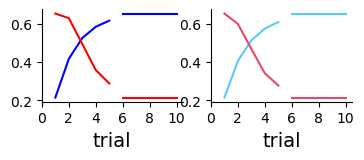

In [41]:
# cue response

block2 = 50
block3 = 100
block4 = 150
block5 = 200

c3 = np.array([92,201,250])/255
c4 = np.array([234,72,105])/255

shortcue_early = (rpe1[block3:(block3+5),t_cue] + rpe2[block4:(block4+5),t_cue])/2
shortcue_late = (rpe1[(block3+45):block4,t_cue] + rpe2[(block4+45):block5,t_cue])/2
longcue_early = (rpe1[block4:(block4+5),t_cue] + rpe2[block3:(block3+5),t_cue])/2
longcue_late = (rpe1[(block4+45):block5,t_cue] + rpe2[(block3+45):block4,t_cue])/2

shortflavorcue_early = (rpe1[block5:(block5+5),t_cue] + rpe2[block2:(block2+5),t_cue])/2
shortflavorcue_late = (rpe1[(block5+45):(block5+50),t_cue] + rpe2[(block2+45):block3,t_cue])/2
longflavorcue_early = (rpe1[block2:(block2+5),t_cue] + rpe2[block5:(block5+5),t_cue])/2
longflavorcue_late = (rpe1[(block2+45):block3,t_cue] + rpe2[(block5+45):(block5+50),t_cue])/2

fig,ax = plt.subplots(1,2,figsize=[4,1.2])

ax[0].plot(np.arange(1,6),shortcue_early,color='blue')
ax[0].plot(np.arange(6,11),shortcue_late,color='blue')
ax[0].plot(np.arange(1,6),longcue_early,color='red')
ax[0].plot(np.arange(6,11),longcue_late,color='red')
ax[0].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[0].xaxis.label.set_fontsize(xfont)
ax[0].yaxis.label.set_fontsize(xfont)

ax[1].plot(np.arange(1,6),shortflavorcue_early,color=c3)
ax[1].plot(np.arange(6,11),shortflavorcue_late,color=c3)
ax[1].plot(np.arange(1,6),longflavorcue_early,color=c4)
ax[1].plot(np.arange(6,11),longflavorcue_late,color=c4)
ax[1].set(xlabel='trial',xticks=np.arange(0,11,2))
ax[1].xaxis.label.set_fontsize(xfont)
ax[1].yaxis.label.set_fontsize(xfont)

sns.despine()



# plt.savefig('Figure5a_classicTD_temporalsequence_cueresponse.png', bbox_inches="tight")

